# Ion dynamics

In this tutorial, you will learn how to:

- define ion pumps  
- update reversal potentials with the Nernst equation  
- diffuse ions within the cell  

Here is a code snippet which you will learn to understand in this tutorial:
```python
import jaxley as jx
from jaxley_mech.channels.l5pc import CaHVA, CaNernstPotential, CaPump


branch = jx.Branch()
cell = jx.Cell(branch, parents=[-1, 0, 0])

# Insert a voltage-gated calcium channel.
cell.insert(CaHVA())

# Insert an ion pump which modifies the intracellular calcium based on the calcium current.
cell.insert(CaPump())

# Insert a mechanism that updates the calcium reversal potential based on the intracellular calcium level.
cell.insert(CaNernstPotential())

# Let the intracellular calcium diffuse within the cell.
cell.diffuse("CaCon_i")
cell.set("axial_resistivity_CaCon_i", 1_000.0)

# Record the intracellular calcium concentration and simulate.
cell.record("CaCon_i")
cacon_i = jx.integrate(cell, t_max=100.0, delta_t=0.025)
```

This tutorial assumes that you have already learned how to [build basic simulations](https://jaxley.readthedocs.io/en/latest/tutorials/01_morph_neurons.html). It is also helpful to have read the tutorial on [how to build ion channel models in Jaxley](https://jaxley.readthedocs.io/en/latest/tutorials/05_channel_and_synapse_models.html).

In [1]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak

First, we define a cell as you saw in the [previous tutorial](https://jaxley.readthedocs.io/en/latest/tutorials/01_morph_neurons.html) and insert sodium, potassium, and leak ion channels:

In [2]:
comp = jx.Compartment()
branch = jx.Branch(comp, ncomp=4)
cell = jx.Cell(branch, parents=[-1, 0, 0, 1, 1, 2, 2])
cell.insert(Na())
cell.insert(K())
cell.insert(Leak())

In this tutorial, we will set up a neuron with detailed calcium dynamcis. We will define all channels and pumps from scratch, but you could also just import these channels from `jaxley-mech` and run:
```python
from jaxley_mech.channels.l5pc import CaHVA, CaPump, CaNernstPotential
cell.insert(CaHVA())  # Insert a voltage-gated calcium channel.
cell.insert(CaPump())  # Insert an ion pump.
cell.insert(CaNernstPotential())  # Insert a mechanism that updates the calcium reversal potential.
```

### A voltage-gated calcium channel

Let's start by defining a voltage-gated calcium ion channel. This is done as is described [in the tutorial on building channel models](https://jaxley.readthedocs.io/en/latest/tutorials/01_morph_neurons.html):

In [3]:
from jaxley.channels import Channel
from jaxley.solver_gate import solve_gate_exponential, save_exp

class CaHVA(Channel):
    """High-Voltage-Activated (HVA) Ca2+ channel"""

    def __init__(self, name=None):
        self.current_is_in_mA_per_cm2 = True
        super().__init__(name)
        self.channel_params = {
            f"{self._name}_gCaHVA": 0.00001,  # S/cm^2
        }
        self.channel_states = {
            f"{self._name}_m": 0.1,  # Initial value for m gating variable
            f"{self._name}_h": 0.1,  # Initial value for h gating variable
            "eCa": 0.0,  # Initial value for reversal potential, mV.
        }
        self.current_name = f"i_Ca"

    def update_states(self, states, dt, voltages, params):
        """Update state of gating variables."""
        prefix = self._name
        ms, hs = states[f"{prefix}_m"], states[f"{prefix}_h"]
        m_new = solve_gate_exponential(ms, dt, *self.m_gate(voltages))
        h_new = solve_gate_exponential(hs, dt, *self.h_gate(voltages))
        return {f"{prefix}_m": m_new, f"{prefix}_h": h_new, "eCa": states["eCa"]}

    def compute_current(self, states, voltages, params):
        """Compute the current through the channel."""
        prefix = self._name
        ms, hs = states[f"{prefix}_m"], states[f"{prefix}_h"]
        ca_cond = params[f"{prefix}_gCaHVA"] * (ms**2) * hs
        current = ca_cond * (voltages - states["eCa"])
        return current

    def init_state(self, states, voltages, params, delta_t):
        """Initialize the state such at fixed point of gate dynamics."""
        prefix = self._name
        alpha_m, beta_m = self.m_gate(voltages)
        alpha_h, beta_h = self.h_gate(voltages)
        return {
            f"{prefix}_m": alpha_m / (alpha_m + beta_m),
            f"{prefix}_h": alpha_h / (alpha_h + beta_h),
        }

    @staticmethod
    def m_gate(v):
        """Voltage-dependent dynamics for the m gating variable."""
        alpha = (0.055 * (-27 - v + 1e-6)) / (save_exp((-27.0 - v + 1e-6) / 3.8) - 1.0)
        beta = 0.94 * save_exp((-75.0 - v + 1e-6) / 17.0)
        return alpha, beta

    @staticmethod
    def h_gate(v):
        """Voltage-dependent dynamics for the h gating variable."""
        alpha = 0.000457 * save_exp((-13.0 - v) / 50.0)
        beta = 0.0065 / (save_exp((-v - 15.0) / 28.0) + 1.0)
        return alpha, beta

Note two things:
- we named the current through this channel as `i_Ca`. This happens by defining `self.current_name = "i_Ca"` and will be useful to define the pump (which depends on the calcium current)
- the current through this channel depends on the reversal potential (named `eCa`): `current = ca_cond * (voltages - u["eCa"])`. The reversal potential will later on be updated based on the intracellular calcium concentration.

Let's insert this channel into our cell:

In [4]:
cell.insert(CaHVA())

### A calcium ion pump

Next, we would like to modify the intracellular calcium ion concentration and then update the calcium reversal potential. In `Jaxley`, everything that modifies intracellular ion concentration is called a `Pump`. A `Pump` is very similar to a `Channel`, with two differences:
- it has to define which ion concentration (Ca, Na,...) should be modified (by setting `self.ion_name = "CaCon_i"`)  
- its `compute_current` method will modify the ion concentration, not the membrane voltage (as would be the case for a `Channel`).

Let's define a `Pump` for calcium ions:

In [5]:
from jaxley.pumps import Pump


class CaPump(Pump):
    """Calcium dynamics tracking inside calcium concentration."""

    def __init__(self, name=None):
        super().__init__(name)
        self.channel_params = {
            f"{self._name}_gamma": 0.05,  # Fraction of free calcium (not buffered).
            f"{self._name}_decay": 80,  # Buffering time constant in ms.
            f"{self._name}_depth": 0.1,  # Depth of shell in um.
            f"{self._name}_minCai": 1e-4,  # Minimum intracell. ca concentration in mM.
        }
        self.channel_states = {"i_Ca": 1e-8, "CaCon_i": 5e-05}
        self.ion_name = "CaCon_i"
        self.current_name = "i_CaPump"

    def update_states(self, states, dt, v, params):
        """Update states if necessary (but this pump has no states to update)."""
        return {"CaCon_i": states["CaCon_i"], "i_Ca": states["i_Ca"]}

    def compute_current(self, states, modified_state, params):
        """Return change of calcium concentration based on calcium current and decay."""
        prefix = self._name
        ica = states["i_Ca"]
        gamma = params[f"{prefix}_gamma"]
        decay = params[f"{prefix}_decay"]
        depth = params[f"{prefix}_depth"]
        minCai = params[f"{prefix}_minCai"]

        FARADAY = 96485  # Coulombs per mole.

        # Calculate the contribution of calcium currents to cai change.
        drive_channel = -10_000.0 * ica * gamma / (2 * FARADAY * depth)
        state_decay = (modified_state - minCai) / decay
        diff = drive_channel - state_decay
        return -diff

    def init_state(self, states, v, params, delta_t):
        """Initialize states of channel."""
        return {}


As you can see, the `CaPump` defines an `ion_name`:
```python
self.ion_name = "CaCon_i"
```
As we had hinted at before, the current that modifies the intracellular calcium concentration depends on the current through the `CaHVA` channel. In the `CaHVA` channel, we had defined `self.current_name = "i_Ca"`, so we can access this current in the `compute_current()` method of the `CaPump`:
```python
ica = states["i_Ca"]
```

Let's add the calcium pump to the cell:

In [6]:
cell.insert(CaPump())

### Updating the calcium reversal potential

The `CaPump` modifies the intracellular calcium ion concentration. So far, however, updating the intracellular calcium ion concentration does not impact the voltage dynamics at all (feel free to check the `CaHVA` channel above: neither its `update_states()` nor its `compute_current()` directly depend on `states["CaCon_i"]`). To change this, we would like to modify the calcium reversal potential `eCa` based on the intracellular calcium concentration (again, check the `CaHVA` channel: its `compute_current()` _does_ depend on `states["eCa"]`).

The update to the reversal potential is done via the Nernst equation, which itself can be implemented via a `Channel` in `Jaxley`. For example:

In [7]:
class CaNernstReversal(Channel):
    """Compute Calcium reversal from inner and outer concentration of calcium."""

    def __init__(self, name=None):
        self.current_is_in_mA_per_cm2 = True
        super().__init__(name)
        self.channel_constants = {
            "F": 96485.3329,  # C/mol (Faraday's constant)
            "T": 279.45,  # Kelvin (temperature)
            "R": 8.314,  # J/(mol K) (gas constant)
        }
        self.channel_params = {}
        self.channel_states = {"eCa": 0.0, "CaCon_i": 5e-05, "CaCon_e": 2.0}
        self.current_name = f"i_Ca"

    def update_states(self, states, dt, voltages, params):
        """Update internal calcium concentration based on calcium current and decay."""
        R, T, F = (
            self.channel_constants["R"],
            self.channel_constants["T"],
            self.channel_constants["F"],
        )
        Cai = states["CaCon_i"]
        Cao = states["CaCon_e"]
        C = R * T / (2 * F) * 1000  # mV
        vCa = C * jnp.log(Cao / Cai)
        return {"eCa": vCa, "CaCon_i": Cai, "CaCon_e": Cao}

    def compute_current(self, states, voltages, params):
        """This dynamics model does not directly contribute to the membrane current."""
        return 0

    def init_state(self, states, voltages, params, delta_t):
        """Initialize the state at fixed point of gate dynamics."""
        return {}

The `CaNernstReversal` modifies the reversal potential `eCa` in its `update_states` method.

We can insert this mechanism as always:

In [8]:
cell.insert(CaNernstReversal())

### Ion diffusion

In principle, we could already run this simulation. Optionally, we can add one more feature: ion diffusion. Ion diffusion can be turned on with the `.diffuse()` method in `Jaxley` (if you do not run the `.diffuse()` method, then ions do not diffuse). In this case, we would like to diffuse the intracellular calcium concentration:

In [9]:
cell.diffuse("CaCon_i")

We can define how strongly calcium diffuses by setting its axial resistivity:

In [10]:
cell.set("axial_resistivity_CaCon_i", 1_000.0)

### Running the simulation

We can now record voltage or intracellular calcium concentration from our cell, stimulate it with a step current, and simulate:

In [11]:
t_max = 20.0
dt = 0.025

cell.delete_recordings()
cell.delete_stimuli()

cell.branch(0).comp(0).record("v")
cell.branch(0).comp(0).record("CaCon_i")
cell.branch(0).comp(0).stimulate(jx.step_current(1.0, 10.0, 0.03, dt, t_max))
v_and_ca = jx.integrate(cell, delta_t=dt, t_max=t_max)

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 external_states. See `.externals` for details.


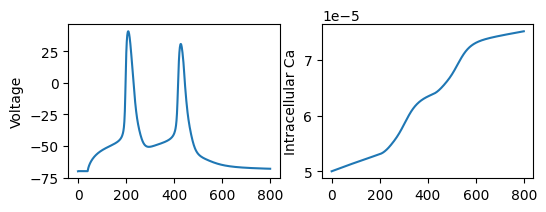

In [12]:
time_vec = np.arange(0, t_max + dt * 2, dt)
fig, ax = plt.subplots(1, 2, figsize=(6, 2))
_ = ax[0].plot(v_and_ca[0])
_ = ax[1].plot(v_and_ca[1])
_ = ax[0].set_ylabel("Voltage")
_ = ax[1].set_ylabel("Intracellular Ca")

That's it! In this tutorial, you should have learned how to model detailed intracellular ion (in particular calcium) dynamics.